In [ ]:
#import libraries
%matplotlib inline
import zipfile # for locations data read
import pandas as pd # for dataframes
import geopandas as gpd
from matplotlib import pyplot as plt

In [ ]:
# load and extract Arlington Street Maps
arlstreet = r'/content/drive/My Drive/Maps/BaseMap_wStreetNames_WebMercator.zip'
extract = r'/content/drive/My Drive/Maps/'
zp = zipfile.ZipFile(arlstreet,mode='r')
zp.extractall(path=extract)

In [ ]:
# load and extract location JSON libraries
#tkout = r'/content/drive/My Drive/Takeout/takeout-20200418T152419Z-001.zip'
#extract = r'/content/drive/My Drive/Takeout/'
#zp = zipfile.ZipFile(tkout,mode='r')
#zp.extractall(path=extract)

In [ ]:
# load in Location History json for to explore safety
data = r'/content/drive/My Drive/Takeout/Takeout/Location History/Location History.json'
df = pd.read_json(data,orient='columns')
# normalize the json dictionary
df = pd.json_normalize(df['locations'])
dft = df

In [ ]:
# determine timestamp types
pd.to_datetime(dft.timestampMs,unit='ms').head()
# adding the unit argument for ms matches expectation that format is milliseconds

#add datetime column
dft.insert(0, 'TimeStamp', pd.to_datetime(dft.timestampMs,unit='ms'))

In [ ]:
#fix some bad longitudes
dft.loc[dft.longitudeE7 > 0,'longitudeE7'] = dft.loc[dft.longitudeE7 > 0, 'longitudeE7'] * -1

#convert latitude and longitude to float
dft['latitude'] = dft.latitudeE7 / 10000000
dft['longitude'] = dft.longitudeE7 / 10000000

In [ ]:
#look at 2020 data after February
dfa = dft[(dft.activity.notnull()) & 
          (dft.TimeStamp.dt.year == 2020) &
          (dft.TimeStamp.dt.month > 2)
          ].reset_index(drop = True)

In [ ]:
#pull Google's top-ranked activity type out of the activity dictionary into it's own field
#assumes that the top ranked activity type is representative of an accurate scoring algo
dfa['act_type'] = None

ctrl = range(len(dfa))

for i in ctrl:
  for dictionary in dfa[dfa.activity.notnull()].activity.iloc[i]:
    if 'activity' in dictionary.keys():
      activities = list(dictionary['activity'])
      b = list()
      for a in activities:
        b.append(a.get('type'))
      b = b[0]
  dfa.at[i, 'act_type'] = b

In [ ]:
#pickle module just in case
import pickle

filename = 'activities'
outfile = open(filename,'wb')
pickle.dump(dfa,outfile)
outfile.close()

In [ ]:
#pickle intake
import pickle

filename = 'activities'
infile = open(filename,'rb')
new_dict = pickle.load(infile)
infile.close()

In [ ]:
new_dict.columns

Index(['TimeStamp', 'timestampMs', 'latitudeE7', 'longitudeE7', 'accuracy',
       'activity', 'altitude', 'verticalAccuracy', 'velocity', 'heading',
       'latitude', 'longitude', 'act_type'],
      dtype='object')

In [ ]:
#get rid of the useless columns
 ndf = new_dict.drop(['timestampMs', 'latitudeE7', 'longitudeE7', 'accuracy',
       'activity', 'altitude', 'verticalAccuracy', 'velocity', 'heading'], axis=1)

In [ ]:
#load points to geography dataframe
gdf = gpd.GeoDataFrame(
    ndf, geometry=gpd.points_from_xy(ndf.longitude, ndf.latitude),crs=4326)

In [ ]:
#note that the longitude data is handled properly
gdf.describe()

,latitude,longitude
count,6666.000000,6666.000000
mean,38.896287,-77.104543
std,0.016125,0.044326
min,38.805362,-77.345159
25%,38.896590,-77.104049
50%,38.896591,-77.104033
75%,38.896593,-77.104032
max,38.977477,-77.014916


In [ ]:
#filter for where it thinks we were on foot
gdf = gdf[gdf.act_type == 'ON_FOOT']

In [ ]:
#arlington streets
path=r'/content/drive/My Drive/Maps/Arlington/34186e0f-82b1-43e6-84be-923d9b41d9a22020316-1-abijaw.x6777.shp'
streets = gpd.read_file(path)

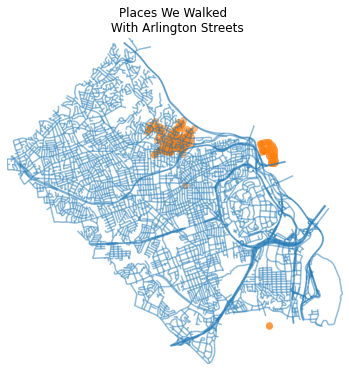

In [ ]:
# Plot the data with a modified spatial extent
fig, ax = plt.subplots(figsize = (10,6))

xlim = ([streets.total_bounds[0],  streets.total_bounds[2]])
ylim = ([streets.total_bounds[1],  streets.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

streets.plot(color='tab:blue',alpha = .5, ax = ax)
gdf.plot(color='tab:orange', ax=ax, alpha=.5)

ax.set(title='Places We Walked \n With Arlington Streets')
ax.set_axis_off()
plt.show()

In [ ]:
streets[streets.STCODE == 'NMNRST'].head()

,OBJECTID,DATESTAMP,STCODE,STBLOCK,STTYPE,STCLASS,L_F_ADD,R_F_ADD,L_T_ADD,R_T_ADD,PLOWTYPE,SPEEDLIMIT,STRTID,STRTTO,STRTFROM,MAJORROAD,STRTDIRP,STRTNAME,STRTTYPE,STRTDIRS,STNAME,DIVIDED,EVACROUTE,ECC_LF,ECC_LT,ECC_RF,ECC_RT,ECC_STNAME,GIS_ID,ONEWAY,ROUTENUMBE,STRMAP,ROAD_WIDTH,ROAD_WID_1,TruckProhi,Owner,Closed_Sta,SHAPElen,SNOW_EMEG_,AccessStat,MTP_TYPE,geometry
738,739,2001-06-28,NMNRST,0,0,35,0,0,0,0,2,25,7221,N017ST,NLINST,0,N,MONROE,ST,None,N MONROE ST,0,0,0,0,0,0,N MONROE ST,2930,None,NaN,0,35.0,NaN,0,ARL,0,234.899632,NaN,NaN,None,"LINESTRING (-8583136.847 4705994.273, -8583145..."
947,948,2009-04-16,NMNRST,800,800,25,800,801,898,899,2,25,722,N009ST,_WSNBLVD,0,N,MONROE,ST,None,N MONROE ST,0,0,800,898,801,899,N MONROE ST,9357,None,NaN,0,44.0,NaN,0,ARL,0,262.662741,NaN,NaN,TYPE B,"LINESTRING (-8583034.230 4704775.033, -8583036..."
1039,1040,1996-02-06,NMNRST,1900,1900,35,1900,1901,1998,1999,2,25,829,N020ST,N019ST,0,N,MONROE,ST,None,N MONROE ST,0,0,1900,1998,1901,1999,N MONROE ST,1046,None,NaN,0,24.0,NaN,0,ARL,0,230.439341,NaN,NaN,None,"LINESTRING (-8583192.928 4706501.102, -8583195..."
1299,1300,1996-01-18,NMNRST,700,700,35,700,701,718,719,2,25,259,N008ST,N007ST,0,N,MONROE,ST,None,N MONROE ST,0,0,700,718,701,719,N MONROE ST,1447,None,NaN,0,35.0,NaN,0,ARL,0,252.703878,NaN,NaN,None,"LINESTRING (-8582935.158 4704525.378, -8582971..."
1883,1884,1996-02-06,NMNRST,1800,1800,35,1800,1801,1898,1899,2,25,825,N019ST,N018ST,0,N,MONROE,ST,None,N MONROE ST,0,0,1800,1898,1801,1899,N MONROE ST,4465,None,NaN,0,25.0,NaN,0,ARL,0,310.405058,NaN,NaN,None,"LINESTRING (-8583187.849 4706379.309, -8583192..."
